# Python Notebook for Parameter Estimation of the Lettuce Growth Model

This notebook implements the steps for estimating a subset of parameters for the lettuce growth model described in *"Validation of a dynamic lettuce growth model for greenhouse climate control"* by Van Henten. The process involves:

1. **Generating Data**: Simulate "true" data for the state variables $X_{nsdw}$ (Non-structural Dry Weight) and $X_{sdw}$ (Structural Dry Weight) by solving the ODE model using known parameter values and environmental inputs.

2. **Adding Noise to Simulate Experimental Measurements**: Perturb the simulated data by adding noise to mimic realistic experimental conditions.

3. **Parameter Estimation**:
    - Define the residual functions.
    - Use optimization techniques (`scipy.optimize.least_squares` and `scipy.optimize.minimize`) to estimate a subset of parameters by minimizing the difference between observed and simulated data.

4. **Visualizing Results**:
    - Compare the true and estimated parameter values.
    - Plot the observed data, true model predictions, and fitted model predictions for $X_{nsdw}$ and $X_{sdw}$.

5. **Post-Estimation Analysis**:
    - Calculate standard errors for the estimated parameters.
    - Evaluate the goodness of fit using metrics such as Theil's Inequality Coefficient (TIC) and Mean Absolute Relative Error (MARE).


The notebook makes use of the [SciPy library](https://scipy.org/), particularly the `scipy.integrate.solve_ivp` function for solving ODEs and the `scipy.optimize` module for parameter estimation. [SciPy documentation](https://docs.scipy.org/doc/scipy/).

## 1. Import libraries

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, least_squares
import matplotlib.pyplot as plt



## 2. Implement the lettuce growth ODE model
This function defines the system of ordinary differential equations for lettuce growth.

In [2]:
def lettuce_ode(t, X, params, inputs):
    """
    Lettuce growth model.

    Args:
        t: Current time (required by ODE solvers)
        X: State vector [X_nsdw, X_sdw] (g m^-2)
        params: Dictionary containing model parameters
        inputs: Dictionary containing environmental inputs

    Returns:
        dXdt: Column vector of derivatives [dX_nsdw/dt, dX_sdw/dt]
    """
    X_nsdw = X[0]  # Non-structural dry weight (g m^-2)
    X_sdw = X[1]   # Structural dry weight (g m^-2)

    # Parameters
    c_alpha = params['c_alpha']
    c_beta = params['c_beta']
    c_gr_max = params['c_gr_max']
    c_gamma = params['c_gamma']
    c_Q10_gr = params['c_Q10_gr']
    c_resp_sht = params['c_resp_sht']
    c_resp_rt = params['c_resp_rt']
    c_tau = params['c_tau']
    c_Q10_resp = params['c_Q10_resp']
    c_K = params['c_K']
    c_lar = params['c_lar']
    c_epsilon = params['c_epsilon']
    c_Gamma = params['c_Gamma']
    c_10_Gamma = params['c_10_Gamma']
    c_bnd = params['c_bnd']
    c_stm = params['c_stm']
    c_car1 = params['c_car1']
    c_car2 = params['c_car2']
    c_car3 = params['c_car3']
    c_w = params['c_w']

    # Inputs
    U_PAR = inputs['U_PAR'] # Incident PAR (W m^-2)
    U_CO2 = inputs['U_CO2'] # CO2 concentration (ppm)
    U_T = inputs['U_T']     # Canopy temperature (degrees C)

    # Intermediate calculations
    # epsilon
    Gamma = c_Gamma * c_10_Gamma**((U_T - 20) / 10)
    if U_CO2 + 2 * Gamma <= 0: # prevents division by zero
        epsilon = 0
    else:
        epsilon = c_epsilon * (U_CO2 - Gamma) / (U_CO2 + 2 * Gamma)
    epsilon = max(0, epsilon) # cannot be negative

    # Carboxylation conductance (1/g_CO2)
    c_car = c_car1 * U_T**2 + c_car2 * U_T + c_car3
    c_car = max(np.finfo(float).eps, c_car)

    g_CO2_inv = (1 / max(np.finfo(float).eps, c_bnd)) + \
                (1 / max(np.finfo(float).eps, c_stm)) + \
                (1 / max(np.finfo(float).eps, c_car))
    g_CO2 = 1 / g_CO2_inv

    # f_phot_max
    phot_denom = epsilon * U_PAR + g_CO2 * c_w * (U_CO2 - Gamma)
    if phot_denom <= 0:
        f_phot_max = 0
    else:
        f_phot_max = (epsilon * U_PAR * g_CO2 * c_w * (U_CO2 - Gamma)) / phot_denom
    f_phot_max = max(0, f_phot_max) # cannot be negative

    # f_phot
    f_phot = (1 - np.exp(-c_K * c_lar * (1 - c_tau) * X_sdw)) * f_phot_max

    # r_gr
    growth_denom = c_gamma * X_sdw + X_nsdw
    if growth_denom <= 0 or X_nsdw < 0:
        r_gr = 0
    else:
        r_gr = c_gr_max * (X_nsdw / growth_denom) * c_Q10_gr**((U_T - 20) / 10)
    r_gr = max(0, r_gr) # cannot be negative

    # f_resp
    f_resp = (c_resp_sht * (1 - c_tau) * X_sdw + c_resp_rt * c_tau * X_sdw) * \
             c_Q10_resp**((U_T - 25) / 10)
    f_resp = max(0, f_resp) # cannot be negative

    # dX_nsdw/dt
    dX_nsdw_dt = c_alpha * f_phot - r_gr * X_sdw - f_resp - \
                 ((1 - c_beta) / c_beta) * r_gr * X_sdw

    # dX_sdw/dt
    dX_sdw_dt = r_gr * X_sdw

    return [dX_nsdw_dt, dX_sdw_dt]


## 3. Load true parameters
This function loads the true value of the parameters (provided by the paper of Van Henten, E. J. (1994) "Sensitivity analysis of a dynamic growth model of lettuce") and define input conditions (constant in this case).

In [36]:
def load_true_parameters():
    """Returns a dictionary of the true model parameters."""
    params = {}
    params['c_alpha']      = 0.68
    params['c_beta']       = 0.8
    params['c_gr_max']     = 5.0e-6
    params['c_gamma']      = 1.0
    params['c_Q10_gr']     = 1.6
    params['c_resp_sht']   = 3.47e-7
    params['c_resp_rt']    = 1.16e-7
    params['c_tau']        = 0.07
    params['c_Q10_resp']   = 2.0
    params['c_K']          = 0.9
    params['c_lar']        = 75.0e-3
    params['c_epsilon']    = 17.0e-6
    params['c_Gamma']      = 40.0
    params['c_10_Gamma']   = 2.0
    params['c_bnd']        = 0.004
    params['c_stm']        = 0.02
    params['c_car1']       = -1.32e-5
    params['c_car2']       = 5.94e-4
    params['c_car3']       = -2.64e-3
    params['c_w']          = 7.32e-3
    return params

true_params = load_true_parameters()
#print("True Parameters:", true_params)

In [37]:

inputs = {
    'U_PAR': 150,  # Incident PAR (W m^-2) 
    'U_CO2': 600,  # CO2 concentration (ppm) 
    'U_T':   22    # Canopy temperature (degrees) 
}
#print("Inputs:", inputs)

## 4. Generate Data

"True" data for $X_{nsdw}$ and $X_{sdw}$ are generated by solving the ODE model using the parameter values and environmental inputs defined earlier. These data represent the idealized behavior of the system.

### 4.1 Solve the ODE

The `scipy.integrate.solve_ivp` function is used to numerically integrate the ODE model. The simulation spans 50 days, with data sampled every 4 days. 


Simulation for 50 days.
Sampling on days: [ 0  4  8 12 16 20 24 28 32 36 40 44 48]


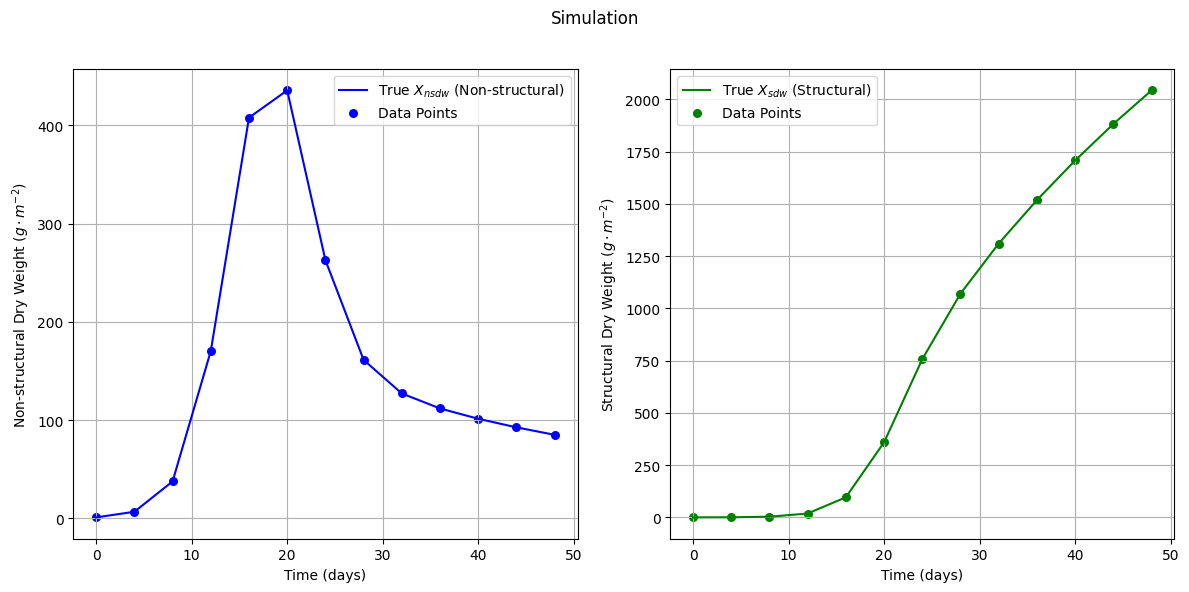

In [ ]:

# Initial conditions for state variables [X_nsdw, X_sdw]
X0 = [1.0, 0.1]  #1g/m^2 non-structural, 0.1g/m^2 structural

# Time span for the simulation
t_days = 50

t_seconds_per_day = 24 * 60 * 60

# Sample the data every 4 days.
sampling_interval_days = 4
num_sampling_points = int(t_days / sampling_interval_days) + 1
sampling_days = np.linspace(0, sampling_interval_days * (num_sampling_points - 1), num_sampling_points)
sampling_days = np.arange(0, t_days + 1, sampling_interval_days)

t_eval_seconds = sampling_days * t_seconds_per_day

t_span_seconds = [0, t_days * t_seconds_per_day]

print(f"Simulation for {t_days} days.")
print(f"Sampling on days: {sampling_days}")

# Solve the ODE
sol_true = solve_ivp(
    fun=lettuce_ode,
    t_span=t_span_seconds,
    y0=X0,
    args=(true_params, inputs),
    t_eval=t_eval_seconds,
    method='RK45' # explicit solver commonly used for ODEs
)

# Extract data
true_X_nsdw = sol_true.y[0, :]
true_X_sdw = sol_true.y[1, :]
time_points_days = t_eval_seconds / t_seconds_per_day

# Plot data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(time_points_days, true_X_nsdw, label='True $X_{nsdw}$ (Non-structural)', color='blue', linestyle='-')
plt.scatter(time_points_days, true_X_nsdw, color='blue', label='Data Points', s=30)
plt.xlabel('Time (days)')
plt.ylabel('Non-structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_points_days, true_X_sdw, label='True $X_{sdw}$ (Structural)', color='green')
plt.scatter(time_points_days, true_X_sdw, color='green', label='Data Points', s=30)
plt.xlabel('Time (days)')
plt.ylabel('Structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.grid(True)

plt.suptitle('Simulation')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### 4.2 Perturb data 

The data generated is perturbed to simulate a realistic scenario, this is done by adding noise to the data. The noise level should scale with the true data's magnitude, to have this the noise is added using a **Coefficient of Variation (CV)** since it is more realistic than fixed absolute noise.
The Coefficient of Variation is the standard deviation divided by the mean ($CV = \sigma / \mu$), representing relative error.
* The standard deviation of the noise at each time point ($\sigma_{noise}$) is calculated as:
    $$\sigma_{noise} = CV \times \text{True Data Value}$$

* value chosen:
    * `cv_nsdw = 0.15` 15% for Non-Structural Dry Weight.
    * `cv_sdw = 0.15` 15% for Structural Dry Weight.


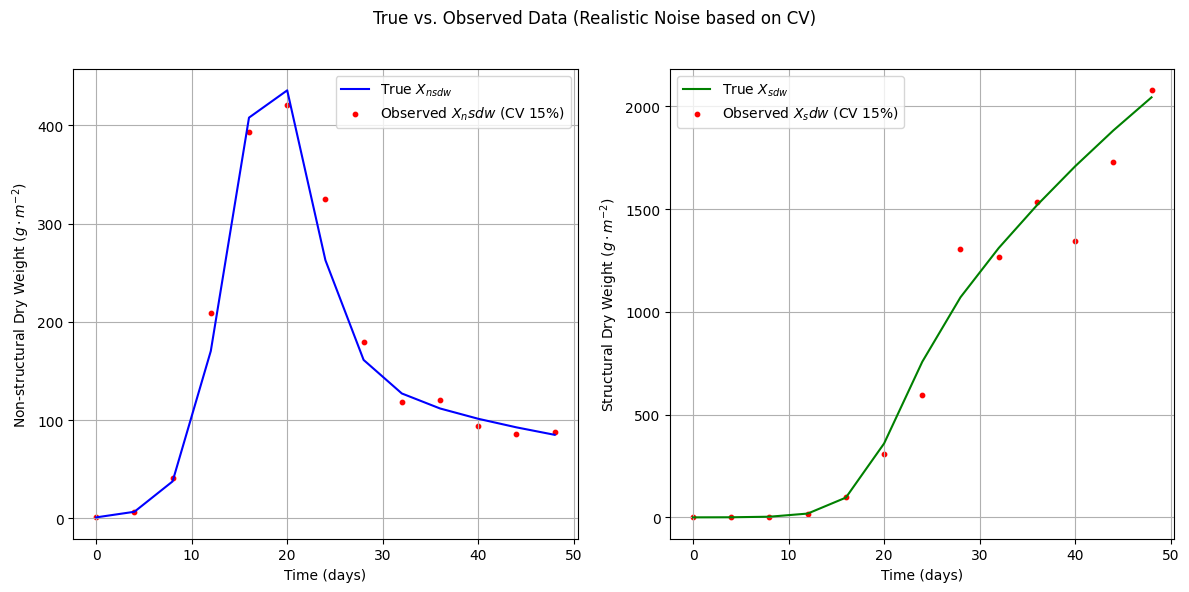

In [45]:
# CV = standard_deviation / mean
# So, standard_deviation_of_noise = CV * true_value
cv_nsdw = 0.15  
cv_sdw = 0.15  

np.random.seed(42)

# Calculate standard deviation of noise at each time point
noise_std_dev_nsdw = cv_nsdw * true_X_nsdw
noise_std_dev_sdw = cv_sdw * true_X_sdw


# Generate noise values from a normal distribution with mean 0 and calculated std dev
noise_values_nsdw = np.random.normal(0, noise_std_dev_nsdw, size=true_X_nsdw.shape)
noise_values_sdw = np.random.normal(0, noise_std_dev_sdw, size=true_X_sdw.shape)

# Add noise 
observed_X_nsdw = true_X_nsdw + noise_values_nsdw
observed_X_sdw = true_X_sdw + noise_values_sdw

observed_X_nsdw = np.maximum(0, observed_X_nsdw)
observed_X_sdw = np.maximum(0, observed_X_sdw) 

# Plot true VS observed data 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(time_points_days, true_X_nsdw, label='True $X_{nsdw}$', linestyle='-', color='blue')
plt.scatter(time_points_days, observed_X_nsdw, label=f'Observed $X_nsdw$ (CV {cv_nsdw*100:.0f}%)', color='red', s=10)
plt.xlabel('Time (days)')
plt.ylabel('Non-structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_points_days, true_X_sdw, label='True $X_{sdw}$', linestyle='-', color='green')
plt.scatter(time_points_days, observed_X_sdw, label=f'Observed $X_sdw$ (CV {cv_sdw*100:.0f}%)', color='red', s=10)
plt.xlabel('Time (days)')
plt.ylabel('Structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.grid(True)

plt.suptitle('True vs. Observed Data (Realistic Noise based on CV)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



 ## 7. Perform parameter estimation

Parameter estimation is done using optimization algorithms available in `scipy.optimize`.

 ### 7.1 Define the residual function and the objective function
    
* **Residual function**:
$$ \text{r}_i = y_{sim}(t_i, \theta_p) - y_{obs}(t_i) $$
   
* **Objective function**:
$$ J(\theta_p) = \sum_{i=1}^{N} \left( (X_{nsdw,sim}(t_i, \theta_p) - X_{nsdw,obs}(t_i))^2 + (X_{sdw,sim}(t_i, \theta_p) - X_{sdw,obs}(t_i))^2 \right) $$
where $N$ is the number of observation time points. 

The residual function and objective function are needed by `scipy.optimize.least_squares` and `scipy.optimize.minimize` respectively to perform the parameter estimation.

In [49]:
parameters_to_estimate_names = ['c_alpha', 'c_beta', 'c_resp_sht', 'c_gr_max'] 

current_params_for_estimation = true_params.copy()

def objective_function(estimated_param_values, param_names_to_estimate, all_params,
                       t_eval_seconds, X0_sim, inputs_sim, observed_nsdw, observed_sdw):
    """
    It runs the model with current parameter guesses and returns the sum of squared errors.
    """
    params_to_simulate = all_params.copy()
    for i, name in enumerate(param_names_to_estimate):
        params_to_simulate[name] = estimated_param_values[i]

    # Run the ODE solver with the updated parameters
    sol_estimated = solve_ivp(
        fun=lettuce_ode,
        t_span=[t_eval_seconds[0], t_eval_seconds[-1]],
        y0=X0_sim,
        args=(params_to_simulate, inputs_sim),
        t_eval=t_eval_seconds,
        method='RK45'
    )

    if not sol_estimated.success or sol_estimated.y.shape[1] != len(t_eval_seconds):
        print(f"Solver failed, params: {estimated_param_values}")
        return np.inf

    sim_X_nsdw = sol_estimated.y[0, :]
    sim_X_sdw = sol_estimated.y[1, :]

    # Calculate the error 
    error_nsdw = np.sum((sim_X_nsdw - observed_nsdw)**2)
    error_sdw = np.sum((sim_X_sdw - observed_sdw)**2)
    
    total_error = error_nsdw + error_sdw
    
    # print(f"params: {dict(zip(param_names_to_estimate, estimated_param_values))}, SSE: {total_error}")
    return total_error


def residuals_function(estimated_param_values, param_names_to_estimate, all_params,
                       t_eval_seconds, X0_sim, inputs_sim, observed_nsdw, observed_sdw):
    """
    Returns a array of residuals: simulated - observed.
    """
    params_to_simulate = all_params.copy()
    for i, name in enumerate(param_names_to_estimate):
        params_to_simulate[name] = estimated_param_values[i]

    sol_estimated = solve_ivp(
        fun=lettuce_ode,
        t_span=[t_eval_seconds[0], t_eval_seconds[-1]],
        y0=X0_sim,
        args=(params_to_simulate, inputs_sim),
        t_eval=t_eval_seconds,
        method='RK45'
    )

    if not sol_estimated.success or sol_estimated.y.shape[1] != len(t_eval_seconds):
        print(f"Solver failed or mismatched output for params: {estimated_param_values}")
        return np.full(len(observed_nsdw) + len(observed_sdw), np.inf)

    sim_X_nsdw = sol_estimated.y[0, :]
    sim_X_sdw = sol_estimated.y[1, :]

    residuals_nsdw = sim_X_nsdw - observed_nsdw
    residuals_sdw = sim_X_sdw - observed_sdw
    
    return np.concatenate([residuals_nsdw, residuals_sdw])


### 7.2 Optimization algorithms
Parameter estimation is done using optimization algorithms available in `scipy.optimize`.

* **Minimization Algorithms**:
    Two optimization approaches from `scipy.optimize` are implemented:
    1.  **`least_squares` with Trust Region Reflective method**, can handle bounds on parameters
    2.  **`minimize` with 'Nelder-Mead' method**

* **Initial Guesses and Bounds**:
    * Initial guesses for the parameters to be estimated are generated by perturbing their true values (±30%).
    * Physically plausible bounds are defined for each parameter being estimated.


In [48]:

initial_guesses = []
parameter_bounds = []

print(f"Estimating parameters: {parameters_to_estimate_names}")
for param_name in parameters_to_estimate_names:
    true_val = true_params[param_name]
    # Example: initial guess is 60% to 140% of the true value
    guess = true_val * (np.random.uniform(0.6, 1.4))
    initial_guesses.append(guess)
    
    # Many parameters in this model are rates or coefficients and should be non-negative.
    # Some parameters have theoretical upper limits.
    lower_bound = 0 
    if param_name == 'c_car1': # This parameter is negative 
        lower_bound = -np.inf 
        upper_bound = 0    
    elif param_name == 'c_beta' or param_name == 'c_alpha' or param_name == 'c_tau': 
        if param_name == 'c_beta':
            lower_bound = 1e-6 #avoids division by zero
        else:
            lower_bound = 0.0
        upper_bound = 1.0
    else: # Case of general positive parameters
        lower_bound = np.finfo(float).eps 
        upper_bound = true_val * 5 

    parameter_bounds.append((lower_bound, upper_bound))


print(f"Initial guesses: {dict(zip(parameters_to_estimate_names, initial_guesses))}")
print(f"Parameter bounds: {dict(zip(parameters_to_estimate_names, parameter_bounds))}")

#  Option 1: Using `scipy.optimize.minimize` with Nelder-Mead

#print("\nStarting optimization with scipy.optimize.minimize...")
#optimization_result_minimize = minimize(
#    fun=objective_function,
#    x0=initial_guesses,
#    args=(parameters_to_estimate_names, true_params.copy(), 
#          t_eval_seconds, X0, inputs, observed_X_nsdw, observed_X_sdw),
#    #method='L-BFGS-B',  # Supports bounds
#    method='Nelder-Mead', # Doesn't use bounds directly 
#    #bounds=parameter_bounds, # Only for methods that support bounds like L-BFGS-B, TNC, SLSQP
#    options={'disp': True, 'ftol': 1e-9, 'gtol': 1e-7} 
#)

# Option 2: Using `scipy.optimize.least_squares` 

print("\nStarting optimization with scipy.optimize.least_squares...")

# bounds ([lowers], [uppers])
ls_bounds = ([b[0] for b in parameter_bounds], [b[1] for b in parameter_bounds])

optimization_result_least_squares = least_squares(
    fun=residuals_function,
    x0=initial_guesses,
    args=(parameters_to_estimate_names, true_params.copy(), 
          t_eval_seconds, X0, inputs, observed_X_nsdw, observed_X_sdw),
    bounds=ls_bounds, 
    method='trf', 
    verbose=2 
)

if optimization_result_least_squares.success:
    estimated_params_ls = optimization_result_least_squares.x
    print("Optimization with least_squares successful.")
    print(f"Estimated parameters (least_squares): {dict(zip(parameters_to_estimate_names, estimated_params_ls))}")
else:
    estimated_params_ls = initial_guesses
    print("Optimization with least_squares failed or did not converge.")
    print(f"Termination status: {optimization_result_least_squares.status}")
    print(f"Message: {optimization_result_least_squares.message}")


if optimization_result_least_squares.success:
    final_estimated_param_values = estimated_params_ls
    print("\nDone.")


Estimating parameters: ['c_alpha', 'c_beta', 'c_resp_sht', 'c_gr_max']
Initial guesses: {'c_alpha': 0.7385043994343825, 'c_beta': 0.5891354391598665, 'c_resp_sht': 2.262583222127136e-07, 'c_gr_max': 6.795542149013333e-06}
Parameter bounds: {'c_alpha': (0.0, 1.0), 'c_beta': (1e-06, 1.0), 'c_resp_sht': (np.float64(2.220446049250313e-16), 1.7350000000000001e-06), 'c_gr_max': (np.float64(2.220446049250313e-16), 2.5e-05)}

Starting optimization with scipy.optimize.least_squares...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2849e+05                                    8.88e+05    
       1              2         1.5686e+05      1.72e+05       3.65e-02       3.03e+05    
       2              3         1.2361e+05      3.32e+04       4.11e-02       6.85e+04    
       3              4         1.0849e+05      1.51e+04       8.00e-02       9.50e+04    
       4              5         1.0536e+05      3.13e+03       2


 ## 8. Visualize results
Compare true vs estimated parameter values

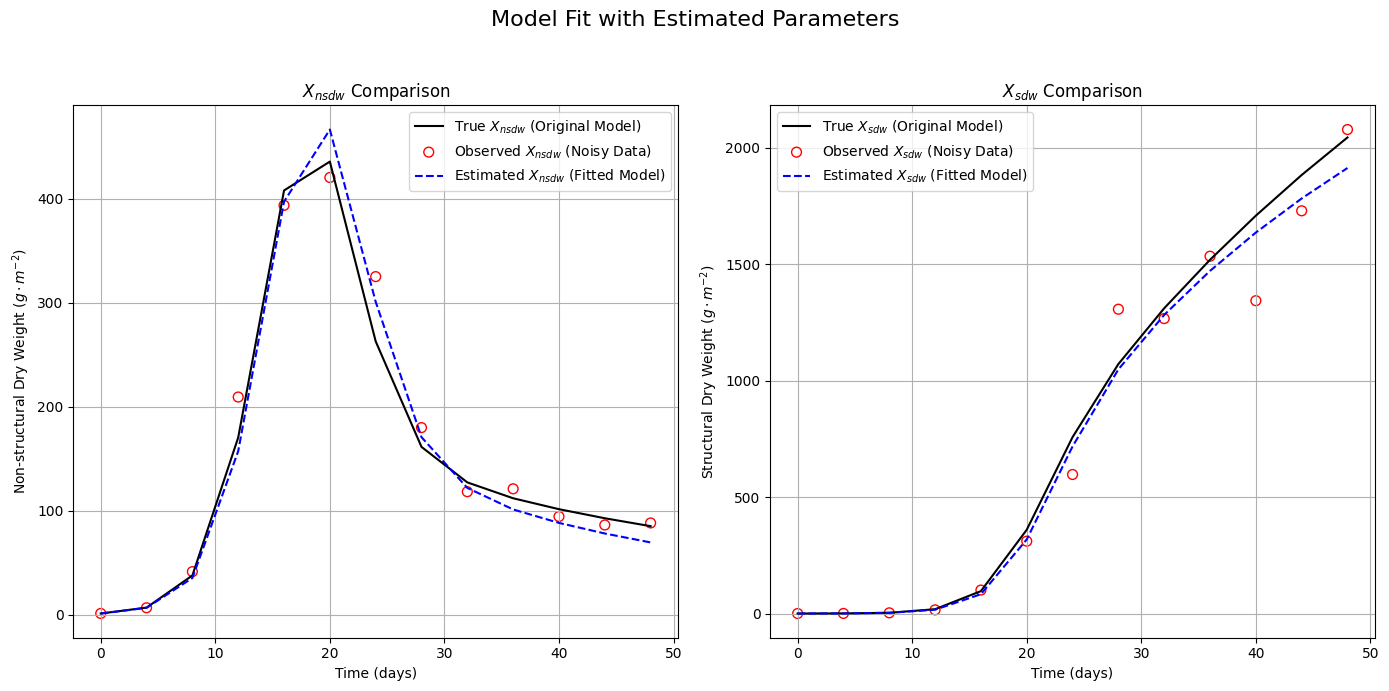


Parameter Comparison:
Parameter       | True Value      | Initial Guess   | Estimated Value     
----------------------------------------------------------------------
c_alpha         | 6.80e-01        | 7.39e-01        | 6.70e-01            
c_beta          | 8.00e-01        | 5.89e-01        | 8.43e-01            
c_resp_sht      | 3.47e-07        | 2.26e-07        | 4.55e-07            
c_gr_max        | 5.00e-06        | 6.80e-06        | 4.87e-06            


In [50]:
# Update the parameter dictionary with the final estimated values
estimated_params_dict = true_params.copy()
for i, name in enumerate(parameters_to_estimate_names):
    estimated_params_dict[name] = final_estimated_param_values[i]

# Simulate the model with the estimated parameters
sol_estimated_final = solve_ivp(
    fun=lettuce_ode,
    t_span=t_span_seconds,
    y0=X0,
    args=(estimated_params_dict, inputs),
    t_eval=t_eval_seconds,
    method='RK45'
)

est_X_nsdw = sol_estimated_final.y[0, :]
est_X_sdw = sol_estimated_final.y[1, :]

# Plotting the results
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(time_points_days, true_X_nsdw, 'k-', label='True $X_{nsdw}$ (Original Model)')
plt.scatter(time_points_days, observed_X_nsdw, facecolors='none', edgecolors='r', label='Observed $X_{nsdw}$ (Noisy Data)', s=50)
plt.plot(time_points_days, est_X_nsdw, 'b--', label='Estimated $X_{nsdw}$ (Fitted Model)')
plt.xlabel('Time (days)')
plt.ylabel('Non-structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.title('$X_{nsdw}$ Comparison')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_points_days, true_X_sdw, 'k-', label='True $X_{sdw}$ (Original Model)')
plt.scatter(time_points_days, observed_X_sdw, facecolors='none', edgecolors='r', label='Observed $X_{sdw}$ (Noisy Data)', s=50)
plt.plot(time_points_days, est_X_sdw, 'b--', label='Estimated $X_{sdw}$ (Fitted Model)')
plt.xlabel('Time (days)')
plt.ylabel('Structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.title('$X_{sdw}$ Comparison')
plt.grid(True)

plt.suptitle('Model Fit with Estimated Parameters', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Compare true vs estimated parameter values
print("\nParameter Comparison:")
print(f"{'Parameter':<15} | {'True Value':<15} | {'Initial Guess':<15} | {'Estimated Value':<20}")
print("-" * 70)
for i, name in enumerate(parameters_to_estimate_names):
    true_val_str = f"{true_params[name]:.2e}"
    init_guess_str = f"{initial_guesses[i]:.2e}"
    est_val_str = f"{final_estimated_param_values[i]:.2e}"
    print(f"{name:<15} | {true_val_str:<15} | {init_guess_str:<15} | {est_val_str:<20}")

#print("\nParameters that were not estimated but kept at true values:")
#for p_name, p_val in true_params.items():
#    if p_name not in parameters_to_estimate_names:
#        print(f"  {p_name}: {p_val:.2e}")


 ## 9. Post-estimation analysis: standard errors, and goodness of fit
 After estimating the parameters using `least_squares`, a statistical analysis is performed
 to understand the uncertainty associated with these estimates and the overall goodness of fit of the model.
 1. Calculate standard errors for each estimated parameter.
 2. Evaluate goodness of fit using TIC and MARE metrics.

 ### 10.1. Standard errors 

The standard error provides a measure of the precision of that estimate. 
When using `scipy.optimize.least_squares`, the result object `optimization_result_least_squares` contains the Jacobian matrix ($J$) evaluated at the solution. This matrix can be used to approximate the covariance matrix of the parameters. The formula is:

$$ \text{Cov}(\hat{\theta}_p) \approx (J^T J)^{-1} \cdot \text{MSE} $$

where:
- $J$ is the Jacobian matrix of the residuals with respect to the parameters, $J^T$ its transpose.
- MSE is the mean squared error, calculated as $\sum (\text{residuals})^2 / \text{dof}$.
    -  $\text{dof}$ represents the degrees of freedom, which is: number of observations (total residual points) - number of estimated parameters.

The standard error for each parameter $\hat{\theta}_k$ is then the square root of the corresponding diagonal element of this estimated covariance matrix:

$$ \sigma(\hat{\theta}_k^*) = \sqrt{(\text{Cov}(\hat{\theta}_p))_{k,k}} $$


In [52]:
if optimization_result_least_squares.success:
    num_observations = len(optimization_result_least_squares.fun) 
                                      
    num_parameters = len(final_estimated_param_values)

    dof = num_observations - num_parameters
    
    # Jacobian matrix at the solution
    jacobian_matrix = optimization_result_least_squares.jac
    
    if dof > 0 and jacobian_matrix is not None:
        print("Calculating Standard Errors...")
        # Residuals at the solution (already computed by least_squares as result.fun)
        residuals_at_solution = optimization_result_least_squares.fun
        
        # Mean Squared Error 
        # sum of squared residuals / degrees of freedom
        mse = np.sum(residuals_at_solution**2) / dof
        
        try:
            # (J^T J)
            jtj = jacobian_matrix.T @ jacobian_matrix
            
            # Inverse of (J^T J)
            # Adding a small identity matrix for numerical stability if jtj is ill-conditioned
            jtj_inv = np.linalg.inv(jtj + np.eye(jtj.shape[0]) * 1e-9) 
            
            # Covariance matrix of parameters
            covariance_matrix = jtj_inv * mse
            
            # Standard errors are the square roots of the diagonal elements
            standard_errors = np.sqrt(np.diag(covariance_matrix))
            
            print("\nEstimated Parameters, Standard Errors, and Relative Standard Errors (RSE):")
            for i, name in enumerate(parameters_to_estimate_names):
                estimated_value = final_estimated_param_values[i]
                se_value = standard_errors[i]
                
                # Calculate RSE as a percentage
                rse_percent = (se_value / np.abs(estimated_value)) * 100
                
                print(f"  {name}: {estimated_value:.4e} ± {se_value:.4e}  (RSE: {rse_percent:.2f}%)")
            
        except np.linalg.LinAlgError:
            print("Error: Could not compute the inverse of J^T J (singular matrix)")
            standard_errors = np.full_like(final_estimated_param_values, np.nan)
            covariance_matrix = None


Calculating Standard Errors...

Estimated Parameters, Standard Errors, and Relative Standard Errors (RSE):
  c_alpha: 6.6951e-01 ± 1.2028e-01  (RSE: 17.97%)
  c_beta: 8.4267e-01 ± 2.0443e-01  (RSE: 24.26%)
  c_resp_sht: 4.5496e-07 ± 1.1431e-07  (RSE: 25.13%)
  c_gr_max: 4.8741e-06 ± 1.6974e-07  (RSE: 3.48%)


### 10.2. Goodness of fit metrics

The metrics implemented to evaluate the goodness of fit measures how well the overall model, using the estimated parameters, reproduces the observed data. 
Two metrics are implemented:
*  Theil's Inequality Coefficient (TIC) 
*  Mean Absolute Relative Error (MARE)

**1. Theil's Inequality Coefficient (TIC)**

The TIC is a measure of forecast accuracy that compares the simulated values to the observed values. It is normalized to be between 0 and 1:
- $TIC = 0$ indicates a perfect fit (simulated values perfectly match observed values).
- $TIC = 1$ indicates the worst possible fit.

The formula is:
$$ \text{TIC} = \frac{\sqrt{\sum_{i=1}^{N} (y_{sim}(t_i) - y_{obs}(t_i))^2}}{\sqrt{\sum_{i=1}^{N} y_{sim}(t_i)^2} + \sqrt{\sum_{i=1}^{N} y_{obs}(t_i)^2}} $$
where $N$ is the total number of data points across all observed states.

**2. Mean Absolute Relative Error (MARE)**

MARE provides a measure of the average relative deviation of the simulated values from the observed values, expressed as a percentage.

The formula is:
$$ \text{MARE} = \frac{1}{N_{state}} \sum_{i=1}^{N_{state}} \left| \frac{y_{obs}(t_i) - y_{sim}(t_i)}{y_{obs}(t_i)} \right| $$
where $N_{state}$ is the number of observations for a specific state variable. MARE will be calculated separately for $X_{nsdw}$ and $X_{sdw}$

In [55]:

# We need the simulated data using the final estimated parameters to calculate these metrics.
# First, let's re-simulate the model with the estimated parameters.

if optimization_result_least_squares.success:
    estimated_params_for_gof_dict = true_params.copy() # Start with all true params
    for i, name in enumerate(parameters_to_estimate_names):
        estimated_params_for_gof_dict[name] = final_estimated_param_values[i]

    sol_estimated_for_gof = solve_ivp(
        fun=lettuce_ode,
        t_span=[t_eval_seconds[0], t_eval_seconds[-1]], 
        y0=X0,
        args=(estimated_params_for_gof_dict, inputs),
        t_eval=t_eval_seconds, 
        method='RK45'
    )
    
    if sol_estimated_for_gof.success:
        sim_X_nsdw_final = sol_estimated_for_gof.y[0, :]
        sim_X_sdw_final = sol_estimated_for_gof.y[1, :]
        
        observed_data_combined = np.concatenate([observed_X_nsdw, observed_X_sdw])
        simulated_data_combined = np.concatenate([sim_X_nsdw_final, sim_X_sdw_final])
        
        # TIC
        
        numerator_tic = np.sqrt(np.sum((simulated_data_combined - observed_data_combined)**2))
        denominator_tic_part1 = np.sqrt(np.sum(simulated_data_combined**2))
        denominator_tic_part2 = np.sqrt(np.sum(observed_data_combined**2))
        
        if (denominator_tic_part1 + denominator_tic_part2) == 0:
            tic_value = np.nan 
        else:
            tic_value = numerator_tic / (denominator_tic_part1 + denominator_tic_part2)
        
        print(f"\nGoodness of fit metrics:")
        print(f"  TIC : {tic_value:.4f} ")

        # MARE
        
        # MARE for X_nsdw
        abs_relative_error_nsdw = np.abs((observed_X_nsdw - sim_X_nsdw_final) / (observed_X_nsdw + 1e-9)) # + 1e-9 is to avoid division by 0
        mare_nsdw = np.mean(abs_relative_error_nsdw)
        print(f"  Mean Absolute Relative Error (MARE) for X_nsdw: {mare_nsdw:.4f} ({mare_nsdw*100:.2f}%)")
        
        # MARE for X_sdw
        abs_relative_error_sdw = np.abs((observed_X_sdw - sim_X_sdw_final) / (observed_X_sdw + 1e-9)) 
        mare_sdw = np.mean(abs_relative_error_sdw)
        print(f"  Mean Absolute Relative Error (MARE) for X_sdw: {mare_sdw:.4f} ({mare_sdw*100:.2f}%)")

    else:
        print("Final simulation for GOF metrics failed.")
else:
    print("Optimization was not successful. Cannot calculate Goodness of Fit metrics.")


Goodness of fit metrics:
  TIC : 0.0575 
  Mean Absolute Relative Error (MARE) for X_nsdw: 0.0992 (9.92%)
  Mean Absolute Relative Error (MARE) for X_sdw: 0.1324 (13.24%)
